# Roughness Mapping from Normal Mapping

This algorithm uses the normalized inverse difference between the height mapping and its blurred version (comparable to a Gaussian difference except that the difference is not absolute but normalized).

In [1]:
from logging import warning
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from skimage import io


In [2]:
IS_NOTEBOOK: bool = True  # @param {type: "boolean"}
ROUGHNESS_MAP_FILE_NAME: str = "roughness.png"  # @param {type: "string"}

PATH_PREFIX: str = (
    "https://raw.githubusercontent.com/YertleTurtleGit/photometric-stereo-mappings/main/test_dataset/"
    if IS_NOTEBOOK
    else "./../test_dataset/"
)

NORMAL_MAP_PATH:str = PATH_PREFIX + "output/normal.png"
MASK_PATH = PATH_PREFIX + "output/opacity.png"

OUTPUT_PATH = None if IS_NOTEBOOK else PATH_PREFIX + "output/" + ROUGHNESS_MAP_FILE_NAME

In [3]:
def _read_image(
    image_path: str, color: bool = True, target_dtype: np.dtype = np.dtype("float64")
) -> np.ndarray:
    """Reads an image from URI and converts it to an array with specified bit depth.

    Args:
        image_path (str): The path to the image file.
        color (bool, optional): Read image as color image. Defaults to True.
        target_dtype (np.dtype, optional): The target bit depth. Defaults to np.dtype("float64").

    Returns:
        np.ndarray: The output array with shape (w,h,3) for color or (w,h) for grayscale images.
    """
    image = io.imread(image_path)
    image_dtype: np.dtype = image.dtype
    image = image.astype(target_dtype)

    if image_dtype == np.dtype("uint8"):
        image /= pow(2, 8) - 1
    elif image_dtype == np.dtype("uint16"):
        image /= pow(2, 16) - 1
    elif image_dtype == np.dtype("uint32"):
        image /= pow(2, 32) - 1

    if color:
        if len(image.shape) == 3:
            return image
        elif len(image.shape) == 2:
            return np.array([image, image, image])
        elif len(image.shape) == 4:
            return np.array([image[:, :, 0], image[:, :, 1], image[:, :, 2]])
        else:
            warning(
                "Image channel count of "
                + str(len(image.shape))
                + " with shape "
                + str(image.shape)
                + " is unknown: "
                + image_path
            )
    else:
        if len(image.shape) == 2:
            return image
        elif len(image.shape) == 3 or len(image.shape) == 4:
            return (image[:, :, 0] + image[:, :, 1] + image[:, :, 2]) / 3
        else:
            warning(
                "Image channel count of "
                + str(len(image.shape))
                + " with shape "
                + str(image.shape)
                + " is unknown: "
                + image_path
            )

    return image

In [4]:
def roughness_map(normal_map_path: str, output_path: str, mask_path: str) -> np.ndarray:
    """Calculates the pseudo roughness.

    Args:
        normal_map_path (str): _description_
        output_path (str): _description_
        mask_path (str, optional): _description_. Defaults to None.
    """
    normal_map = _read_image(normal_map_path, color=False)
    mask_image = _read_image(mask_path, color=False)

    blurred_normal_map = cv.blur(normal_map, (3, 3))
    blurred_mask = cv.blur(mask_image, (3, 3))

    roughness_map = normal_map - blurred_normal_map
    roughness_map[blurred_mask > 0] *= blurred_mask[blurred_mask > 0]
    roughness_map[blurred_mask < 1] *= 0.01

    roughness_map *= -1
    roughness_map -= np.min(roughness_map)
    roughness_map /= np.max(roughness_map)
    roughness_map[mask_image == 0] = 0

    if output_path:
        cv.imwrite(output_path, np.clip(roughness_map * 255, 0, 255).astype("uint8"))
    else:
        plt.imshow(roughness_map)

    return roughness_map


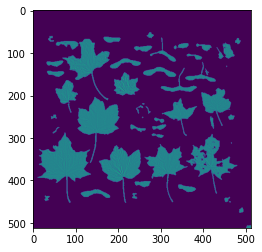

In [5]:
if __name__=="__main__":
    roughness_map(NORMAL_MAP_PATH, OUTPUT_PATH, MASK_PATH)